In [24]:
!pip install torch torchvision transformers opencv-python scikit-learn thop

In [25]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()


,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [26]:
# Verify column names
print(df.columns)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [27]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
from thop import profile

In [28]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [29]:
df.head()

,id,caption,label
1057,1058,পাইলটের শেষ মুহূর্তের প্রচেষ্টা সত্ত্বেও দুর্ঘ...,Anthropogenic
5868,5869,প্যাডেল এক্সারসাইজার মিনি এক্সারসাইজ বাইক আর্ম...,Non Informative
4195,4196,দেশাল ব্লাউজ কালেকশনে প্রতিটি ব্লাউজে রয়েছে হা...,Non Informative
4837,4838,খিচুড়ি - হাস ভুনা - আমের আচার 🌻🌻,Non Informative
4354,4355,কালকে ওরে সোফার রুমে ঘুমে রেখে এসে আমি বেডরুমে...,Non Informative


In [30]:
# Define label mapping
label_mapping = {
    'flood': 0,
    'Cyclone': 1,
    'Earthquake': 2,
    'River Erosion': 3,
    'Fire' : 4,
    'Anthropogenic': 5,
    'Non Informative': -1  # Will be filtered out
}

# Apply label mapping and remove 'Non Informative' rows
df['label'] = df['label'].map(label_mapping)
df = df[df['label'] != -1].reset_index(drop=True)

In [31]:
import random
# Data augmentation functions
def random_deletion_bn(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    remaining = [w for w in words if random.uniform(0,1) > p]
    if not remaining:
        return random.choice(words)
    return ' '.join(remaining)

def random_swap_bn(text, n=1):
    words = text.split()
    length = len(words)
    if length < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(length), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def char_noise_bn(text, p=0.03):
    noisy_text = ''
    for c in text:
        if random.uniform(0,1) < p and c != ' ':
            noisy_text += random.choice('অআইঈউঊঋএঐওঔকখগঘচছজঝটঠডঢতথদধনপফবভমযরলশষসহ')
        else:
            noisy_text += c
    return noisy_text

def augment_bengali_text(text):
    aug_choice = random.choice(['delete', 'swap', 'char_noise', 'none'])
    if aug_choice == 'delete':
        return random_deletion_bn(text, p=0.1)
    elif aug_choice == 'swap':
        return random_swap_bn(text, n=1)
    elif aug_choice == 'char_noise':
        return char_noise_bn(text, p=0.03)
    else:
        return text

# Apply augmentation to training data
train_data, val_test = train_test_split(df, train_size=0.6, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=0.5, random_state=42)
train_data['caption_aug'] = train_data['caption'].apply(augment_bengali_text)

In [32]:
# # Split the dataset
# train_ratio = 0.6
# val_ratio = 0.2
# test_ratio = 0.2

# train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
# valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

In [33]:
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()


In [34]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [35]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
embedding_matrix = bert_model.get_input_embeddings().weight.detach().numpy()
embedding_dim = embedding_matrix.shape[1]  # 768
vocab_size = embedding_matrix.shape[0]  # 101,975

tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

In [36]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, images_folder, tokenizer, image_transforms):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'Fire' : 4,
            'anthropogenic': 5
        }
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = str(row['caption'])
        label = int(row['label'])
        image_id = str(row['id']).strip()

        image_path = os.path.join(self.images_folder, f"{image_id}.jpg")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.png")
        if not os.path.exists(image_path):
            image_path = os.path.join(self.images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image {image_id} not found")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)
        text_inputs = self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        assert 0 <= label <= 5, f"Label {label} out of range"

        return {
            'input_ids': text_inputs['input_ids'].squeeze(),
            'attention_mask': text_inputs['attention_mask'].squeeze(),
            'image': image,
            'label': torch.tensor(label, dtype=torch.long),
            'original_label': self.index_to_class[label]
        }

In [37]:
images_folder = '/kaggle/input/mddb-images/Photos_Final'  # Updated to match dataset source
train_dataset = MultimodalDataset(train_data, images_folder, tokenizer, train_transforms)
valid_dataset = MultimodalDataset(valid_data, images_folder, tokenizer, valid_test_transforms)
test_dataset = MultimodalDataset(test_data, images_folder, tokenizer, valid_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [38]:

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

1899
633
634


In [39]:
import torch
import torch.nn as nn
from torchvision import models

class EarlyFusionModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=6, lstm_layers=1, dropout=0.3, emb_matrix=None, freeze_emb=False):
        super(EarlyFusionModel, self).__init__()

        # Text branch
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        if emb_matrix is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(emb_matrix, dtype=torch.float32))
            self.embedding.weight.requires_grad = not freeze_emb

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=lstm_layers,
                            dropout=dropout if lstm_layers > 1 else 0,
                            batch_first=True, bidirectional=True)

        self.text_norm = nn.LayerNorm(hidden_dim * 2)

        # Image branch: ViT
        self.vit = models.vit_b_16(pretrained=True)
        vit_embed_dim = self.vit.heads.head.in_features
        self.vit.heads = nn.Identity()  # Remove classifier

        self.image_proj = nn.Linear(vit_embed_dim, hidden_dim * 2)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2 + hidden_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask, image):
        # Text
        x = self.embedding(input_ids)              # [B, T, E]
        x = nn.functional.dropout(x, p=0.3, training=self.training)
        x, _ = self.lstm(x)                        # [B, T, 2H]

        mask = attention_mask.unsqueeze(-1).expand(-1, -1, x.size(-1))  # [B, T, 2H]
        x = x * mask
        summed = x.sum(dim=1)
        count = mask.sum(dim=1).clamp(min=1e-9)
        text_features = summed / count
        text_features = self.text_norm(text_features)

        # Image: ViT
        image_features = self.vit(image)                  # [B, 768]
        image_features = self.image_proj(image_features)  # [B, 2H]

        # Fusion
        combined = torch.cat((text_features, image_features), dim=1)
        return self.fc(combined)


In [40]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EarlyFusionModel(
    vocab_size,
    embedding_dim,
    hidden_dim=256,
    num_classes=6,
    emb_matrix=embedding_matrix,
    freeze_emb=True
).to(device)
# Loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-5)

# Scheduler remains the same
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Training loop with early stopping
num_epochs = 10
patience = 3
early_stop_counter = 0
best_valid_loss = float('inf')
best_model_path = 'best_model.pth'
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(input_ids,attention_mask, images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * input_ids.size(0)

    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids,attention_mask, images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * input_ids.size(0)

    valid_loss /= len(valid_dataset)
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")

    scheduler.step(valid_loss)

    # Early stopping
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), best_model_path)
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load(best_model_path))
# model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-40-a4b420a812ae>:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/10:   0%|          | 0/119 [00:00<?, ?it/s]<ipython-input-40-a4b420a812ae>:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.a

Epoch 1/10, Train Loss: 1.6346, Val Loss: 1.3545


Epoch 2/10: 100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


Epoch 2/10, Train Loss: 1.2238, Val Loss: 1.0731


Epoch 3/10: 100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


Epoch 3/10, Train Loss: 0.9592, Val Loss: 0.9832


Epoch 4/10: 100%|██████████| 119/119 [00:54<00:00,  2.17it/s]


Epoch 4/10, Train Loss: 0.8007, Val Loss: 0.8941


Epoch 5/10: 100%|██████████| 119/119 [00:54<00:00,  2.17it/s]


Epoch 5/10, Train Loss: 0.6967, Val Loss: 0.9579


Epoch 6/10: 100%|██████████| 119/119 [00:54<00:00,  2.19it/s]


Epoch 6/10, Train Loss: 0.6418, Val Loss: 0.9486


Epoch 7/10: 100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


Epoch 7/10, Train Loss: 0.5721, Val Loss: 0.9829
Early stopping triggered at epoch 7


<ipython-input-40-a4b420a812ae>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>


Test Set Evaluation:
Accuracy: 0.7713
Precision: 0.7792
Recall: 0.7713
F1 Score: 0.7714

Classification Report:
               precision    recall  f1-score   support

        flood       0.78      0.91      0.84       114
      cyclone       0.67      0.65      0.66        93
   earthquake       0.60      0.73      0.66        84
river erosion       0.80      0.79      0.80       101
         fire       0.89      0.86      0.87       112
anthropogenic       0.85      0.68      0.76       130

     accuracy                           0.77       634
    macro avg       0.77      0.77      0.76       634
 weighted avg       0.78      0.77      0.77       634



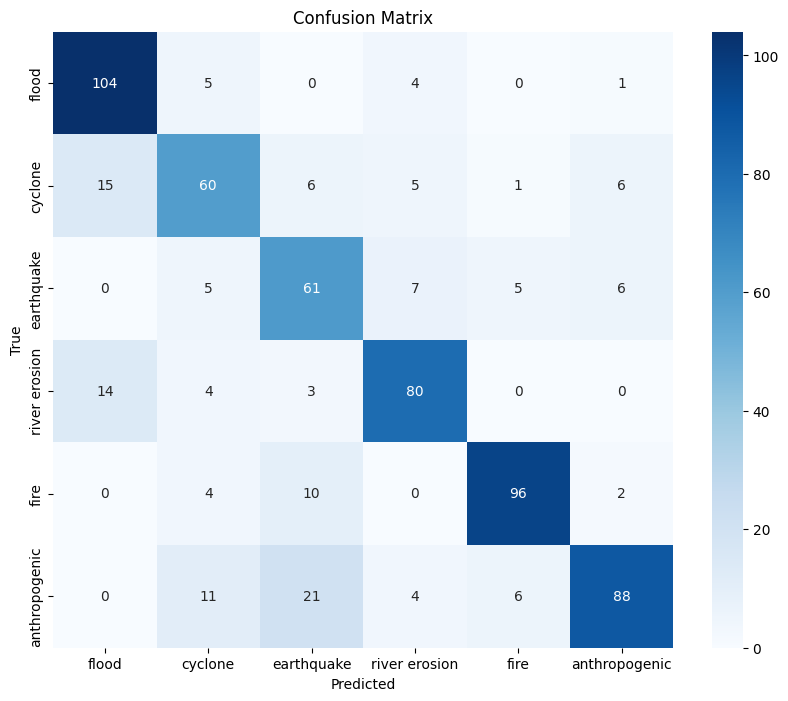

In [41]:
# Evaluation on test set
true_labels = []
pred_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids,attention_mask, images)
        _, preds = torch.max(outputs, dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic']))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'], yticklabels=['flood', 'cyclone', 'earthquake', 'river erosion','fire', 'anthropogenic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


📉 Epoch-wise Losses:
Epoch  1: Train Loss = 1.6346, Val Loss = 1.3545
Epoch  2: Train Loss = 1.2238, Val Loss = 1.0731
Epoch  3: Train Loss = 0.9592, Val Loss = 0.9832
Epoch  4: Train Loss = 0.8007, Val Loss = 0.8941
Epoch  5: Train Loss = 0.6967, Val Loss = 0.9579
Epoch  6: Train Loss = 0.6418, Val Loss = 0.9486
Epoch  7: Train Loss = 0.5721, Val Loss = 0.9829


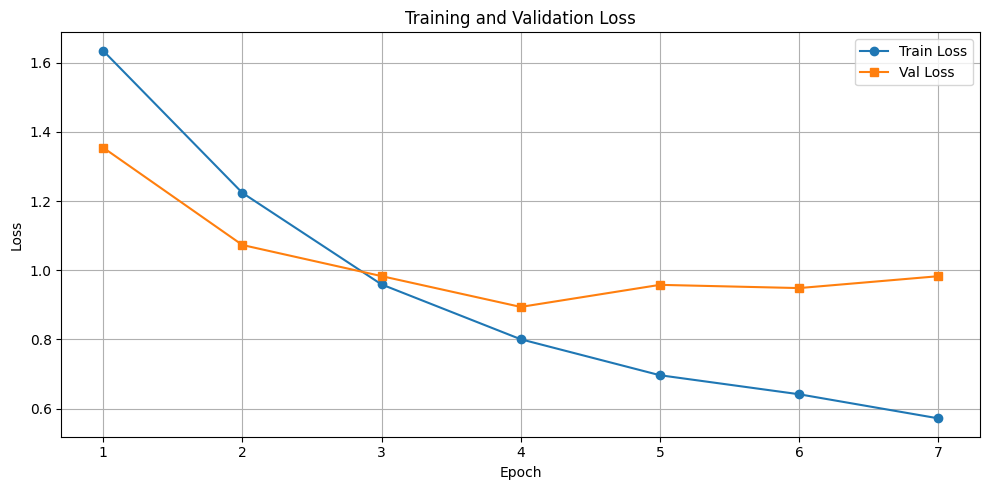

In [42]:
import matplotlib.pyplot as plt

# Print epoch-wise losses
print("\n📉 Epoch-wise Losses:")
for i, (train, val) in enumerate(zip(train_losses, valid_losses), start=1):
    print(f"Epoch {i:2d}: Train Loss = {train:.4f}, Val Loss = {val:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Val Loss', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
